# Dynamic optimization

In [1]:
from platform import python_version
print(python_version())

3.8.10


## Index
1. starting from single shots
    https://media.xiph.org/video/derf/
    ftp://svtopencontent.svt.se
2. coding raw videos in AVC, HEVC, VP9 (in seguito ed eventualmente AV1 e VVC) using:
    - ffmpeg library for AVC
    - TODO
    
3. script per generazione automatica di codifiche multiple, in python, includendo anche risoluzioni fino a 4k (sulle 10 risoluzioni proposte dal paper, selezionarne 5 e aggiungerne 2 oltre l'HD) con convex hull RD dei singoli shot e visualizzazione in MATLAB

4. valutazione risultati con PSNR, MSSIM e soprattutto VMAF e comparazione per contenuto dei singoli shot

5. memorizzazione risultati su csv

6. divisione video in spezzoni con ffmpeg

7. script python per generazione dell'intero video codificato seguendo i passi descritti finora per ogni shot e con convex hull generale; test su 3 titoli: ritmo lento, azione e animazione

8. valutazione risultati come punto e. anche in base alla durata degli shot

In [18]:
#show info
!ffprobe -hide_banner test_vids/smithy.mov

test_vids/smithy.mov: No such file or directory


In [19]:
!ffprobe -hide_banner test_vids/encoded/smithyAVC_1280_cf23.mp4

Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'test_vids/encoded/smithyAVC_1280_cf23.mp4':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf58.29.100
  Duration: 00:00:30.00, start: 0.000000, bitrate: 3682 kb/s
  Stream #0:0[0x1](und): Video: h264 (High) (avc1 / 0x31637661), yuv420p(progressive), 1280x720, 3677 kb/s, 50 fps, 50 tbr, 12800 tbn (default)
    Metadata:
      handler_name    : VideoHandler
      vendor_id       : [0][0][0][0]


[1920  1080; 1536  864; 1216  684; 960  540; 768  432; 608  342; 480  270; 384  216; 320  180; 256  144]

In [ ]:
!ffplay -f rawvideo -video_size 640x360 test_vids/downsampled/smithy_640.yuv

In [3]:
import subprocess
import json
command="ffprobe -v error -select_streams v:0 -show_entries format:stream -print_format json test_vids/encoded/smithyHEVC_cf34.mp4"
cout = subprocess.run(command.split(), stdout=subprocess.PIPE, stderr=subprocess.STDOUT).stdout
dict = json.loads(cout)  # Convert data from JSON string to dictionary
print(dict)

{'programs': [], 'streams': [{'index': 0, 'codec_name': 'hevc', 'codec_long_name': 'H.265 / HEVC (High Efficiency Video Coding)', 'profile': 'Main', 'codec_type': 'video', 'codec_tag_string': 'hev1', 'codec_tag': '0x31766568', 'width': 3840, 'height': 2160, 'coded_width': 3840, 'coded_height': 2160, 'closed_captions': 0, 'film_grain': 0, 'has_b_frames': 2, 'pix_fmt': 'yuv420p', 'level': 153, 'color_range': 'tv', 'chroma_location': 'left', 'field_order': 'progressive', 'refs': 1, 'id': '0x1', 'r_frame_rate': '50/1', 'avg_frame_rate': '50/1', 'time_base': '1/12800', 'start_pts': 0, 'start_time': '0.000000', 'duration_ts': 384000, 'duration': '30.000000', 'bit_rate': '5591491', 'nb_frames': '1500', 'extradata_size': 2202, 'disposition': {'default': 1, 'dub': 0, 'original': 0, 'comment': 0, 'lyrics': 0, 'karaoke': 0, 'forced': 0, 'hearing_impaired': 0, 'visual_impaired': 0, 'clean_effects': 0, 'attached_pic': 0, 'timed_thumbnails': 0, 'captions': 0, 'descriptions': 0, 'metadata': 0, 'depen

32


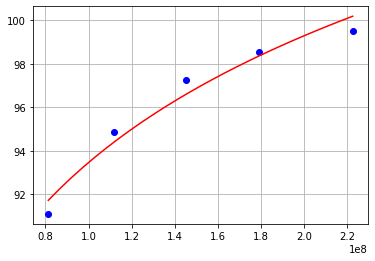

In [161]:
import json
import numpy as np
import matplotlib.pyplot as pl
from scipy.optimize import curve_fit

def find_closest(arr, val):
    idx = (np.abs(arr - val)).argmin()
    return idx
def log_fit(x, a, b, c):
    return a * np.log(x + b) + c

source = "forest"
filepath = "rd_results/rd_" + source + ".json"
bitrates = []
vmafs = []

with open(filepath, 'r') as r:
    i_data = json.load(r)
for item in i_data:
    if(item["codec"] == "vp9"):
        bitrates.append(item["bitrate"])
        vmafs.append(item["vmaf"])
num_samples = (max(bitrates) - min(bitrates)) / 26

popt, pcov = curve_fit(log_fit, bitrates, vmafs, maxfev=2000)
xnew = np.arange(min(bitrates), max(bitrates)+num_samples, num_samples)
interp_vmaf = log_fit(xnew, *popt)
pl.plot(bitrates, vmafs, 'bo')
pl.plot(xnew, interp_vmaf, 'r')
pl.grid(True)

target_bitrate = 12000000
target_vmaf = 98
opt_dist = True
if(opt_dist):
    cfr = find_closest(interp_vmaf, target_vmaf)
else:
    cfr = find_closest(xnew, target_bitrate)
print(cfr + 15)
    